In [1]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
gpus = tf.config.experimental.list_physical_devices("GPU")
print(gpus)
import numpy as np
import math
import pandas
from matplotlib import pyplot as plt
from PIL import Image
import os


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
locloc = "BigData" 
namename = "\TestBigPastel"
all_photos = np.load(locloc + namename + 'Photos.npy')
#all_labels = np.load(locloc + namename + 'Labels.npy') # Эта штука соответствует одному из значений в all_degrees, котрое соответствует некой маске
all_vectors = np.load(locloc + namename + 'Vectors.npy')
#all_degrees = np.load(locloc + namename + 'RotationDegrees.npy')
#all_albedos = np.load(locloc + namename + 'Albedos.npy')
all_normals = np.load(locloc + namename + 'Normals.npy')
all_masks = np.load(locloc + namename + 'Masks.npy')
# Цель просто сделать рабочий генератор маски.

In [4]:
"""
all_masks = all_masks[:, :, :, 0] + all_masks[: , : , :, 1] + all_masks[: , :, :, 2]
all_masks *= (1.0/all_masks.max())
plt.imshow(all_masks[0])
print(all_masks.shape) """

'\nall_masks = all_masks[:, :, :, 0] + all_masks[: , : , :, 1] + all_masks[: , :, :, 2]\nall_masks *= (1.0/all_masks.max())\nplt.imshow(all_masks[0])\nprint(all_masks.shape) '

In [5]:
def masstestAlt(mylist, locmodel):
    vectors = all_vectors[mylist]
    albedos = all_albedos[mylist]
    inputs = all_normals[mylist]
    testanswers = answerList[mylist]
    photos = all_photos[mylist]

    imgimg = locmodel.predict([inputs, vectors])

    differencemap = list()
    for i in range(imgimg.shape[0]):
        differencemap.append(normalizeNegativeImage(testanswers[i], all_masks[mylist[i]]))
    differencemapPred = list()
    for i in range(imgimg.shape[0]):
        differencemapPred.append(normalizeNegativeImage(imgimg[i], all_masks[mylist[i]]))
        
    
    result = albedos + imgimg
    result = np.clip(result, 0 ,1)
    #testanswers = np.clip(testanswers, 0 ,1)

    checkcheck = np.clip(albedos + testanswers,0,1)
    
    r0 =  np.concatenate(inputs, axis=1)
    r1 =  np.concatenate(differencemapPred, axis=1)
    r2 =  np.concatenate(differencemap, axis=1)
    r3 =  np.concatenate(result, axis=1)  
    r4 =  np.concatenate(checkcheck, axis=1)
    
    #r3 =  np.concatenate(np.take(intotheflames, [4,5,6,7], axis=0), axis=0)
    #r4 =  np.concatenate(np.take(imgimg, [4,5,6,7], axis=0), axis=0)
    #r5 =  np.concatenate(np.take(testanswers, [4,5,6,7], axis=0), axis=0)
    finalimage = np.concatenate([r0, r1, r2, r3,  r4], axis=0)
                                 #r3,r4, r5], 
    return finalimage

In [6]:
def GetDifference(num_images):
    photo = all_photos[num_images]
    albedo = all_albedos[num_images]
    mask = all_masks[num_images]
    return photo - albedo * mask
def normalizeNegativeImage(imim, mask):
    nonneg = imim - np.ones(imim.shape) * imim.min()
    nonneg = nonneg * (1.0/nonneg.max())
    return nonneg * mask

In [17]:
batch_size = 64
train_size = 1
lightjumps = 57
# Test Dataset нужно грузить отдельно
 
answerList = list()
print(len(all_photos))
for i in range(len(all_photos)):
    answerList.append(
        GetDifference(i)
    )               
answerList = np.array(answerList)

datasetX = tf.data.Dataset.from_tensor_slices((all_normals, all_vectors))
datasetY = tf.data.Dataset.from_tensor_slices(answerList)

dataset = tf.data.Dataset.zip((datasetX, datasetY))
dataset = dataset.shuffle(buffer_size=512, seed=13)

train_dataset = dataset.batch(64, drop_remainder=True)
print(all_photos.shape, answerList.shape)

6840
(6840, 64, 64, 3) (6840, 64, 64, 3)


106
[ 0.375 -0.927  0.   ]


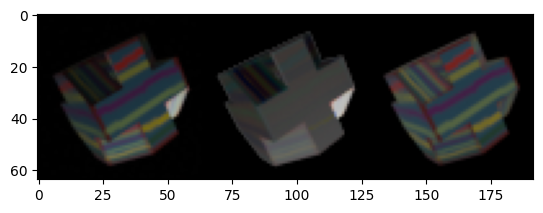

In [21]:
print(len(list(train_dataset)))
def PhotoNormalMask(imtoshownum):
    imtoshow = np.concatenate( [
        all_photos[imtoshownum], 
        normalizeNegativeImage(answerList[imtoshownum], all_masks[imtoshownum]), 
        all_photos[imtoshownum] - answerList[imtoshownum]
        #np.repeat(answerList[imtoshownum][...,3:], 3, axis=2) 
    ]
                              , axis=1).astype("float32")
    plt.imshow(imtoshow)
print(all_vectors[2000])
PhotoNormalMask(2000)

In [46]:
def GiveModel():
    image_input = keras.layers.Input(shape=(64, 64, 3), name='image_input')
    x = keras.layers.Conv2D(4, (3, 3), activation='relu', padding="same")(image_input)
    x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = keras.layers.Conv2D(7, (3, 3), activation='relu', padding="same")(x)
    x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = keras.layers.Flatten()(x)
    
    vector_input = keras.layers.Input(shape=(3,), name='vector_input')
    y = keras.layers.Dense(256, activation='relu')(vector_input)
    
    # Объединение выходов
    combined = keras.layers.concatenate([x, y])
    
    # Полносвязный слой
    z = keras.layers.Dense(2*16*16, activation='tanh')(combined)
    do = keras.layers.Dropout(0.4)(z)
    z = keras.layers.Dense(4*16*16, activation='tanh')(do)
    do = keras.layers.Dropout(0.4)(z)
    z = keras.layers.Dense(4*16*16, activation='tanh')(do)
    do = keras.layers.Dropout(0.4)(z)
    z = keras.layers.Dense(4*16*16, activation='tanh')(do)
    do = keras.layers.Dropout(0.4)(z)
    z = keras.layers.Dense(4*16*16, activation='tanh')(do)
    do = keras.layers.Dropout(0.4)(z)
    

    resh = keras.layers.Reshape((16, 16, 4))(do)
    anticonv1 = keras.layers.Conv2DTranspose(4, (3, 3), strides=(2,2), padding='same', activation='tanh')(resh)
    output = keras.layers.Conv2DTranspose(3, (3, 3), strides=(2,2), padding='same', activation='tanh')(anticonv1)
    
    # Создание модели
    model = keras.models.Model(inputs=[image_input, vector_input], outputs=output)
    return model

In [47]:
g_optimizer_image=keras.optimizers.Adam(learning_rate=0.00004)

In [48]:
model = GiveModel()
model.compile(optimizer=g_optimizer_image, loss='mse')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input (InputLayer)       [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_2 (Conv2D)              (None, 64, 64, 4)    112         ['image_input[0][0]']            
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 32, 32, 4)   0           ['conv2d_2[0][0]']               
                                                                                                  
 conv2d_3 (Conv2D)              (None, 32, 32, 7)    259         ['max_pooling2d_2[0][0]']        
                                                                                            

In [49]:
model.fit(train_dataset, epochs=100)

Epoch 1/100
106/106 [==============================] - 3s 19ms/step - loss: 0.0317
Epoch 2/100
106/106 [==============================] - 2s 18ms/step - loss: 0.0292
Epoch 3/100
106/106 [==============================] - 2s 18ms/step - loss: 0.0287
Epoch 4/100
106/106 [==============================] - 2s 18ms/step - loss: 0.0285
Epoch 5/100
106/106 [==============================] - 2s 18ms/step - loss: 0.0283
Epoch 6/100
106/106 [==============================] - 2s 17ms/step - loss: 0.0282
Epoch 7/100
106/106 [==============================] - 2s 17ms/step - loss: 0.0281
Epoch 8/100
106/106 [==============================] - 2s 17ms/step - loss: 0.0279
Epoch 9/100
106/106 [==============================] - 2s 17ms/step - loss: 0.0275
Epoch 10/100
106/106 [==============================] - 2s 17ms/step - loss: 0.0266
Epoch 11/100
106/106 [==============================] - 2s 17ms/step - loss: 0.0254
Epoch 12/100
106/106 [==============================] - 2s 17ms/step - loss: 0.0241
E

1/1 [==============================] - 0s 21ms/step
(640, 768, 3)
Сверху вниз: Ввод // Разница(Пред.) // Разница(Факт.) // Результат (Пред.) // Результат (Факт.)  


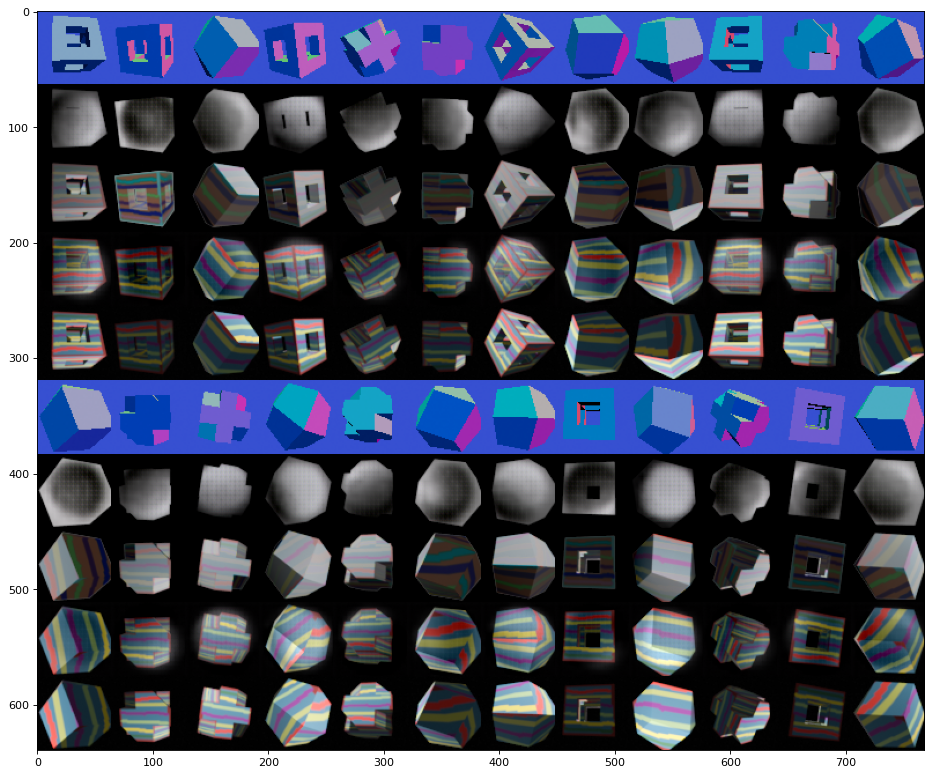

In [50]:
toinset = np.array([0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500])
bigpicture = masstestAlt(toinset, model)
toinset1 = np.array([250, 750, 1250, 1750, 2250, 2750, 3250, 3750, 4250, 4750, 5250, 5750])
bigpicture1 = masstestAlt(toinset1, model)
bigpicture = np.concatenate([bigpicture, bigpicture1], axis=0)
print(bigpicture.shape)
plt.figure(figsize=(16, 12), dpi=80)
print("Сверху вниз: Ввод // Разница(Пред.) // Разница(Факт.) // Результат (Пред.) // Результат (Факт.)  ")
plt.imshow(bigpicture.astype("float32"))

In [27]:
#model.evaluate(test_dataset) Эвалуация потом

4/4 [==============================] - 0s 7ms/step
1.2025531828403473 -0.17929381132125854


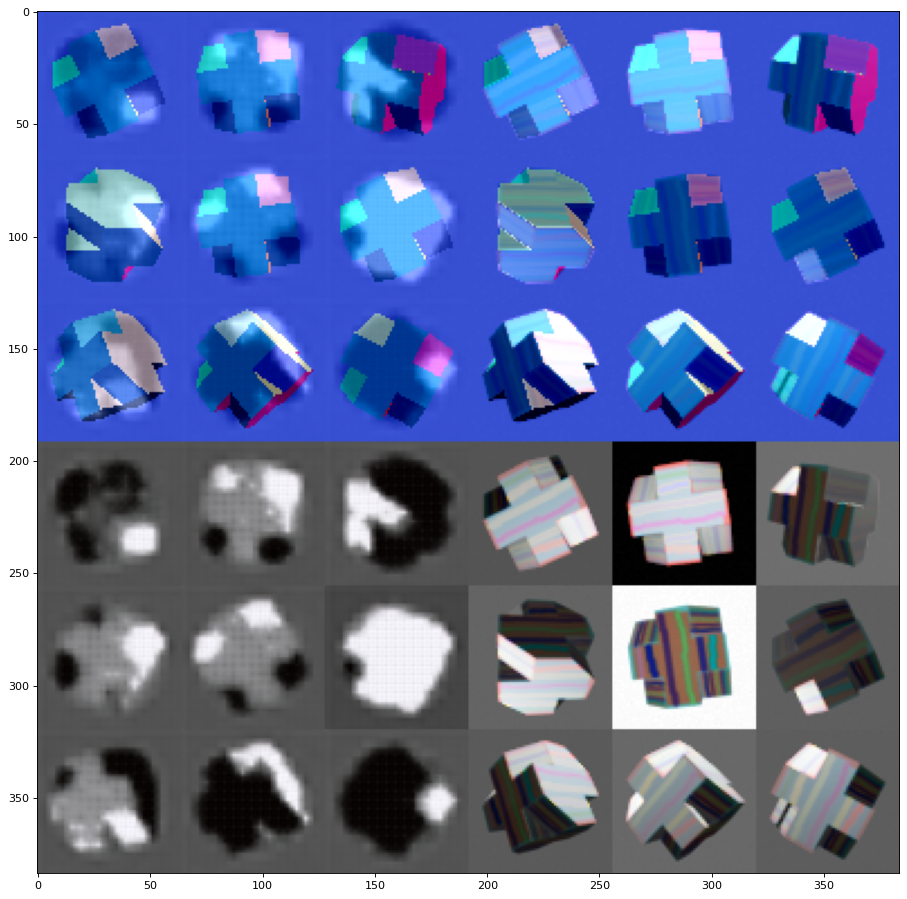

In [45]:
imgoutput = model.predict(test_dataset)
every_24th_image = imgoutput[::24]

dumblist = list(test_dataset)
dumb_albedos = np.empty((0,64,64,3))
for i in range(len(dumblist)):
    dumb_albedos = np.concatenate([dumb_albedos, dumblist[i][0][0]], axis=0)
dumb_answers = np.empty((0,64,64,3))
for i in range(len(dumblist)):
    dumb_answers = np.concatenate([dumb_answers, dumblist[i][1]], axis=0)
combined_image_fake = np.zeros((192, 192, 3))
combined_image_true = np.zeros((192, 192, 3))
raw_fake = np.zeros((192, 192, 3))
raw_true = np.zeros((192, 192, 3))
for i in range(3):  
    for j in range(3):  
        index = i * 4 + j
        raw_fake[i * 64:(i + 1) * 64, j * 64:(j + 1) * 64] =  (
            (every_24th_image[index] - every_24th_image[index].min()) / every_24th_image[index].ptp()
        )
        
        raw_true[i * 64:(i + 1) * 64, j * 64:(j + 1) * 64] = (
            (dumb_answers[index * 24] - dumb_answers[index * 24].min()) / dumb_answers[index * 24].ptp()
        )

        combined_image_fake[i * 64:(i + 1) * 64, j * 64:(j + 1) * 64] = dumb_albedos[index * 24] + every_24th_image[index]
        combined_image_true[i * 64:(i + 1) * 64, j * 64:(j + 1) * 64] = dumb_albedos[index * 24] + dumb_answers[index*24]

print(combined_image_fake.max(), combined_image_fake.min())
combined_image_fake = np.clip(combined_image_fake, 0 ,1 )
combined_image_true = np.clip(combined_image_true, 0 ,1 )
combined_image_image = np.concatenate([combined_image_fake, combined_image_true], axis=1)
combined_raw_image = np.concatenate([raw_fake, raw_true], axis=1)
combined_super_image = np.concatenate([combined_image_image, combined_raw_image], axis=0)
plt.figure(figsize=(14, 14), dpi=80)
plt.imshow(combined_super_image) 

In [86]:
#model.save("somewhatgoodrubic.keras")
# Попытка 1, 300 эпох. 
# Явно что модель не понимает вообще ничего и просто выдает случаюную форму кубика, 
# Иногда она вообще не совпадает со входным изображением

In [46]:
#model.save("overfitgoodrubic.keras")
# Попытка 2, 1500 эпох. Добавил +2 глубоких слоя.
# Выход модели приобрел форму светового шарика освещения, вроде бы это круто
# Иногда она вообще не совпадает со входным изображением